     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 460kB 34.0MB/s 
     |████████████████████████████████| 92kB 11.4MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Mounted at /content/gdrive
Epoch 1/20
43/43 [==============================] - 9s 33ms/step - loss: 2.7226 - acc: 0.2309 - val_loss: 2.1068 - val_acc: 0.3882

Epoch 00001: val_acc improved from -inf to 0.38816, saving model to anythingNLP.h5
Epoch 2/20
43/43 [==============================] - 0s 11ms/step - loss: 1.4165 - acc: 0.6485 - val_loss: 0.7695 - val_acc: 0.8487

Epoch 00002: val_acc improved from 0.38816 to 0.84868, saving model to anythingNLP.h5
Epoch 3/20
43/43 [==============================] - 0s 11ms/step - loss: 0.4340 - acc: 0.9382 - val_loss: 0.1928 - val_acc: 0.9803

Epoch 00003: val_acc improved from 0.84868 to 0.98026, saving model to anythingNLP.h5
Epoch 4/20
4

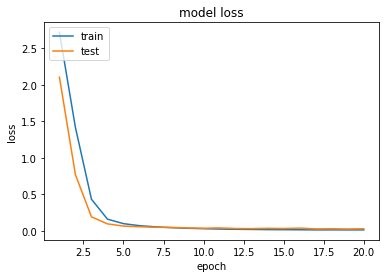

In [1]:
!pip install konlpy
import codecs
from konlpy.tag import Okt
from google.colab import drive
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, BatchNormalization, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')
okt = Okt()

fname = codecs.open("/content/gdrive/MyDrive/NLP/NAME.txt", 'r', 'utf-8')
fexplane = codecs.open("/content/gdrive/MyDrive/NLP/EXPLANE.txt", 'r', 'utf-8')

# explane.txt 에서 형태소 토큰화 후 [[sentences]]에 저장
sentences = []
temp = []

while True:
    line = fexplane.readline()
    if not line: break
    
    line = line.replace("쇼파","소파")
    line = line.replace("슈퍼","수퍼")
    line = line.replace("아기","유아")
    line = line.replace("아이","어린이")
    line = line.replace("커텐","커튼")
    
    sentence = okt.pos(line)
    words = []
    for morpheme in sentence:
        if morpheme[1] in ['Noun', 'Verb', 'Adjective']:
            words.append(morpheme[0])    
            temp.append(morpheme[0])        
    if words:
        sentences.append(words)

# {단어 : 빈도수}로 {vocab}에 저장
vocab = {}
for word in temp:
    if word not in vocab:
        vocab[word] = 0
    vocab[word] += 1

# {vocab}을 높은 빈도수를 가진 단어일수록 낮은 정수 인덱스를 부여해 {word_to_index}에 저장
vocab_sorted = sorted(vocab.items(), key = lambda x:x[1], reverse = True)
word_to_index = {}
word_to_index['<unk>'] = 1

i=1
for (word, frequency) in vocab_sorted :
    if frequency > 1 : # 빈도수가 1보다 큰 단어만 추가
        i=i+1
        word_to_index[word] = i

# {word_to_index}에서 빈도수가 높은 상위 개의 단어만 저장
rank = 1000
words_frequency = [w for w,c in word_to_index.items() if c >= rank] 
for w in words_frequency:
    del word_to_index[w]

# [[sentences]]를 {vocab}을 이용해 정수 인코딩해 [[encoded]]로 저장
encoded = []
for s in sentences:
    temp = []
    for w in s:
        try:
            temp.append(word_to_index[w])
        except KeyError:
            temp.append(word_to_index['<unk>'])
    encoded.append(temp)

# [encoded] 패딩
encoded = pad_sequences(encoded, padding = 'post')

# 라벨 정수 인코딩
furniture_category = ['가죽소파', '소파베드', '더블/퀸/킹침대', '싱글/수퍼싱글+침대', '디반침대', 
                      '옷장', '어린이옷장', '바테이블', '커피테이블/보조테이블', '식탁',  
                      '식탁의자', '바의자', '사무용의자', '스툴/벤치', '어린이의자', '영아용의자', 
                      '가죽암체어', '라탄암체어', '리클라이너', '커튼', '샤워커튼', '블라인드'] # 22개

label = []
while True:
    line = fname.readline()
    if not line: break
    line = line.rstrip('\n')
    line = line.rstrip('\r')
    label.append(furniture_category.index(line))
     
fexplane.close()
fname.close()

encoded = np.array(encoded)
label = np.array(label)
label = to_categorical(label)

# 훈련 데이터를 훈련 데이터와 테스트 데이터로 나누기
x_train, x_test, y_train, y_test = train_test_split(encoded, label, test_size=.1, random_state=777)

# 인공신경망 구현
model = Sequential()
model.add(Embedding(rank, 128)) # 128 차원을 가지는 임베딩 벡터 1000개(단어 집합의 크기)
model.add(Bidirectional(GRU(120)))
model.add(Dense(len(furniture_category), activation='softmax')) # 34개의 카테고리

# 검증 데이터 손실이 증가하면, 과적합 징후이므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# 검증 데이터의 정확도가 이전보다 좋아질 경우에만 모델을 저장(Model Checkpoint)
mc = ModelCheckpoint('anythingNLP.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 다중 클래스 분류 문제이므로 손실 함수로 categorical_crossentropy 사용
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(x_train, y_train, batch_size=32, epochs=20, callbacks=[es, mc], validation_data=(x_test, y_test))

epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save("/content/gdrive/MyDrive/NLP/anythingNLP.h5", save_format='h5')

In [2]:
print(word_to_index)
print(y_train.shape)

{'<unk>': 1, '수': 2, '침대': 3, '의자': 4, '있습니다': 5, '테이블': 6, '할': 7, '사용': 8, '옷장': 9, '싱글': 10, '소파': 11, '어린이': 12, '식탁': 13, '더블': 14, '퀸': 15, '킹': 16, '보조': 17, '가죽': 18, '커튼': 19, '커피': 20, '입니다': 21, '수납': 22, '제품': 23, '공간': 24, '등': 25, '커버': 26, '용': 27, '되어': 28, '구성': 29, '체어': 30, '개': 31, '수퍼': 32, '베드': 33, '쉽게': 34, '포함': 35, '바': 36, '블라인드': 37, '있어요': 38, '쿠션': 39, '있어': 40, '있어서': 41, '하는': 42, '하여': 43, '소재': 44, '매트리스': 45, '있는': 46, '조절': 47, '가구': 48, '합니다': 49, '잘': 50, '프레임': 51, '시트': 52, '옷': 53, '고정': 54, '무용': 55, '하면': 56, '선반': 57, '영아': 58, '하세요': 59, '때': 60, '바닥': 61, '스툴': 62, '보호': 63, '다른': 64, '추가': 65, '된': 66, '높이': 67, '및': 68, '벽': 69, '편안하게': 70, '줍니다': 71, '벤치': 72, '탄': 73, '다리': 74, '이상': 75, '됩니다': 76, '더욱': 77, '않습니다': 78, '안정': 79, '보': 80, '이': 81, '아래': 82, '디자인': 83, '느낌': 84, '시리즈': 85, '서랍': 86, '해': 87, '따라': 88, '처리': 89, '표면': 90, '수도': 91, '마': 92, '별도': 93, '받침': 94, '패': 95, '브릭': 96, '적합합니다': 97, '몸': 98, '나': 99, '원목': 100, '

In [3]:
!pip install konlpy
import codecs
from konlpy.tag import Okt
from google.colab import drive
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

drive.mount('/content/gdrive')
okt = Okt()

fquery = codecs.open("/content/gdrive/MyDrive/NLP/쿼리문.txt", 'r', 'utf-8')
model = load_model("/content/gdrive/MyDrive/NLP/anythingNLP.h5")

querys = []
time = 0
correct = 0

furniture_category = ['가죽소파', '소파베드', '더블/퀸/킹침대', '싱글/수퍼싱글+침대', '디반침대', 
                      '옷장', '어린이옷장', '바테이블', '커피테이블/보조테이블', '식탁',  
                      '식탁의자', '바의자', '사무용의자', '스툴/벤치', '어린이의자', '영아용의자', 
                      '가죽암체어', '라탄암체어', '리클라이너', '커튼', '샤워커튼', '블라인드'] # 22개
while True:
    line = fquery.readline()
    if not line: break
    line = line.replace("쇼파","소파")
    line = line.replace("슈퍼","수퍼")
    line = line.replace("아기","유아")
    line = line.replace("아이","어린이")
    line = line.replace("커텐","커튼")
    
    if line[0] != '-' and line[0] != '\r':
        furniture = line.rstrip('\n')
        furniture = furniture.rstrip('\r')
        furniture = furniture.rstrip('\t')
        continue
    if line[0] == '-':
        a = line.rstrip('\n')
        a = a.lstrip('-')
        a = a.rstrip('\r')
        a = a.rstrip('\t')
        querys.append(a)
        continue
    for query in querys:
        time += 1
        morphemes = []
        search_token = []
        morphemes = okt.pos(query)
        for morpheme in morphemes:
            if morpheme[1] in ['Noun','Verb','Adjective']:
                search_token.append(morpheme[0])          

        temp = []
        search_encoded = []
        for token in search_token:
            try:
                temp.append(word_to_index[token])
            except:
                temp.append(word_to_index['<unk>'])
        search_encoded.append(temp)
        search_encoded = pad_sequences(search_encoded, maxlen = 33, padding = 'post')        
        search_encoded = np.array(search_encoded)        
        predict = model.predict_classes(search_encoded)[0]              
        label = furniture_category[predict]        
        
        if furniture == label:
            correct += 1
        else:
            print("정답 : " + furniture + " / 쿼리 : " + query + " / 오답 : " + label)
                                
        querys = []

print(correct/time)
fquery.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


정답 : 샤워커튼 / 쿼리 : 목욕 커튼 / 오답 : 커튼
0.9836065573770492
